In [1]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')

df.columns = df.columns.str.strip().str.replace(" ", "_")

## Препроцессинг

Повторим бейзлайн решение, обучив начальные модели 

In [2]:
df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
df["Policy_Year"] = df["Policy_Start_Date"].dt.year
df["Policy_Month"] = df["Policy_Start_Date"].dt.month
df["Policy_Day"] = df["Policy_Start_Date"].dt.day

In [3]:
numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

In [4]:
X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(df, numerical_features, binary_features, ordinal_features, nominal_features)
baseline_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test, 
                                 "Бейзлайн")


ЭКСПЕРИМЕНТ: Бейзлайн
Train shape: (960000, 39), Test shape: (240000, 39)
{'model': 'DecisionTreeRegressor', 'mse': 849766.301189081, 'rmse': np.float64(921.8276960414463), 'mae': 622.8141455968585, 'r2': -0.13713728321217622, 'rmsle': np.float64(1.0507390599892081)}
{'model': 'RandomForestRegressor', 'mse': 862373.0876211964, 'rmse': np.float64(928.640451208753), 'mae': 626.5411957929497, 'r2': -0.154007388385083, 'rmsle': np.float64(1.0615979875516908)}
{'model': 'XGBoost', 'mse': 859747.3439568513, 'rmse': np.float64(927.2256165339973), 'mae': 625.43499733874, 'r2': -0.15049367995406282, 'rmsle': np.float64(1.0533180971674656)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 39
[LightG

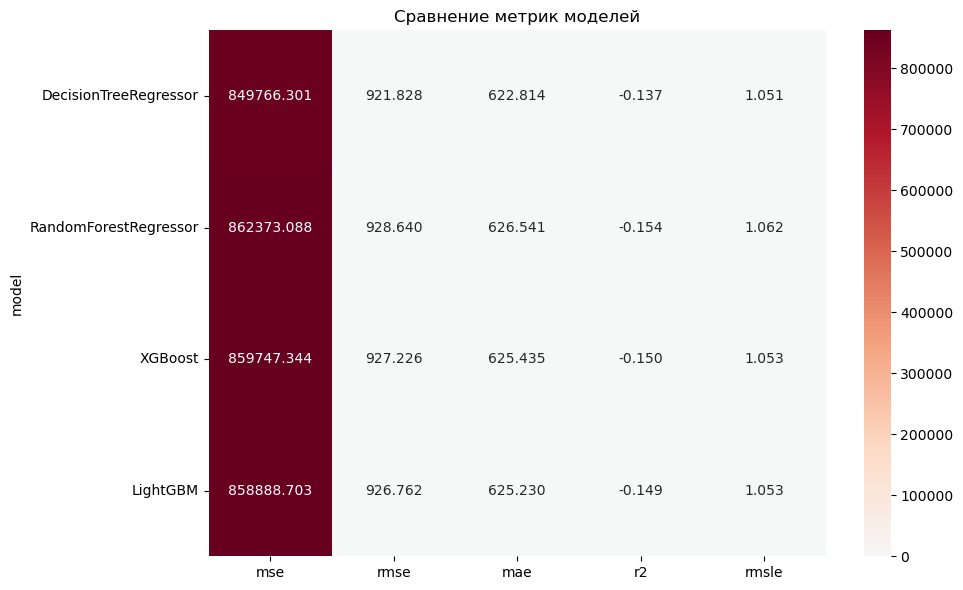

In [5]:
baseline_metrics = compare_models_metrics(baseline_results)

## Feature engineering

Будем использовать итеративный подход, поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего.

### Подход №1

При анализе числовых признаков, Annual_Income т.е. доход клиента оказался сильно ассиметричным. Попробуем перевести его в категориальный, произведя бинаризацию:

In [6]:
def calculate_age_bins(df):
    """
    Бинаризирует группу дохода клиента
    """
    df["Income_Group"] = pd.qcut(df["Annual_Income"], q=4, labels=["Low Income", "Mid-Low", "Mid-High", "High Income"])    
    return df


ЭКСПЕРИМЕНТ: Бинаризация группы дохода клиента
Train shape: (960000, 40), Test shape: (240000, 40)
{'model': 'DecisionTreeRegressor', 'mse': 849901.2377424324, 'rmse': np.float64(921.9008828189895), 'mae': 622.4967821584708, 'r2': -0.13731785213503112, 'rmsle': np.float64(1.05058627288655)}
{'model': 'RandomForestRegressor', 'mse': 860696.9804666247, 'rmse': np.float64(927.7375601249659), 'mae': 625.5221051717076, 'r2': -0.1517644612020974, 'rmsle': np.float64(1.059598141201432)}
{'model': 'XGBoost', 'mse': 857390.1927070005, 'rmse': np.float64(925.9536666091886), 'mae': 624.6716608575821, 'r2': -0.1473393955765523, 'rmsle': np.float64(1.05164893821748)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 960000, number of u

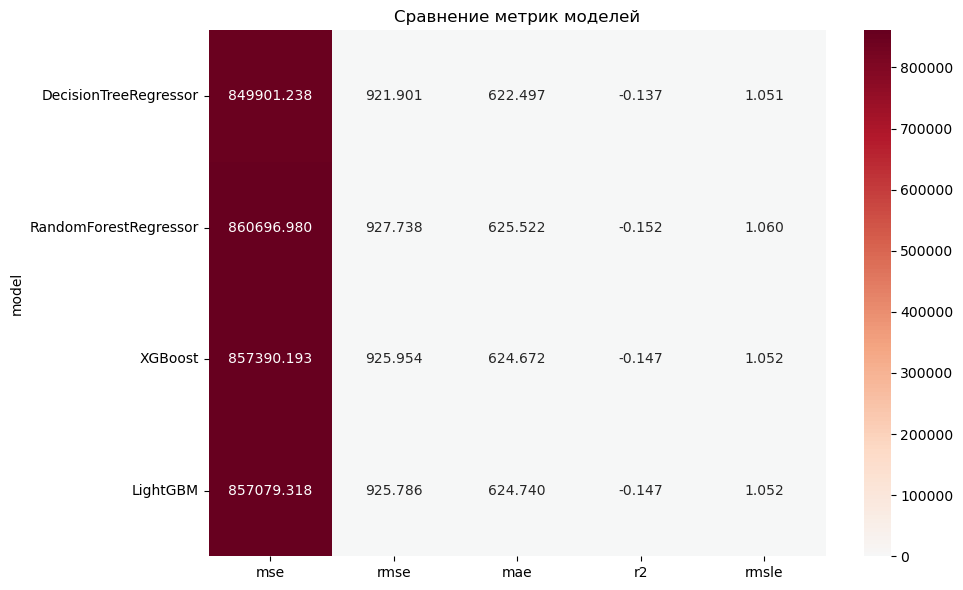

In [7]:
df_exp1 = calculate_age_bins(df)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1 = get_baseline_preprocessing(df_exp1, numerical_features, binary_features, ordinal_features, nominal_features)
exp1_results = run_experiment(X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1,
                             "Бинаризация группы дохода клиента")

exp1_metrics = compare_models_metrics(exp1_results)

,mse,rmse,mae,r2,rmsle
model,,,,,
DecisionTreeRegressor,134.936553,0.073187,-0.317363,-0.000181,-0.000153
RandomForestRegressor,-1676.107155,-0.902891,-1.019091,0.002243,-0.002000
XGBoost,-2357.151250,-1.271950,-0.763336,0.003154,-0.001669
LightGBM,-1809.385100,-0.976701,-0.490489,0.002421,-0.001095


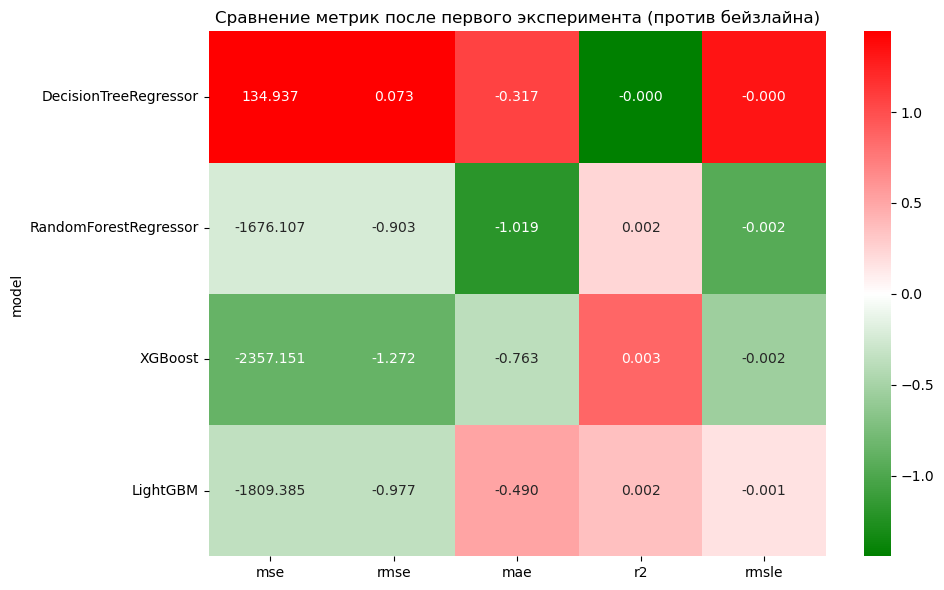

In [8]:
compare_after_add(exp1_metrics, baseline_metrics, 'Сравнение метрик после первого эксперимента (против бейзлайна)')

Снизились среднеквадратичные ошибки и MAE для всех моделей кроме случайного леса

### Подход №2

Сделаем аналогичное преобразования для признака Health_Score:

In [9]:
def calculate_health_bins(df):
    """
    Бинаризирует рейтинг здоровья клиента
    """
    df["Health_Risk_Level"] = pd.qcut(df["Health_Score"], q=3, labels=["High Risk", "Medium Risk", "Low Risk"])
    
    return df


ЭКСПЕРИМЕНТ: Бинаризация рейтинга здоровья
Train shape: (960000, 41), Test shape: (240000, 41)
{'model': 'DecisionTreeRegressor', 'mse': 850880.886344041, 'rmse': np.float64(922.4320497164227), 'mae': 622.5074768283494, 'r2': -0.13862879485866797, 'rmsle': np.float64(1.0504079041190826)}
{'model': 'RandomForestRegressor', 'mse': 859000.6513815632, 'rmse': np.float64(926.8228802643811), 'mae': 624.49728809916, 'r2': -0.14949447350722012, 'rmsle': np.float64(1.0582645444989938)}
{'model': 'XGBoost', 'mse': 856365.4194896317, 'rmse': np.float64(925.4001402040263), 'mae': 623.8951049144109, 'r2': -0.14596806815314567, 'rmsle': np.float64(1.0502166099620327)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 960000, number of u

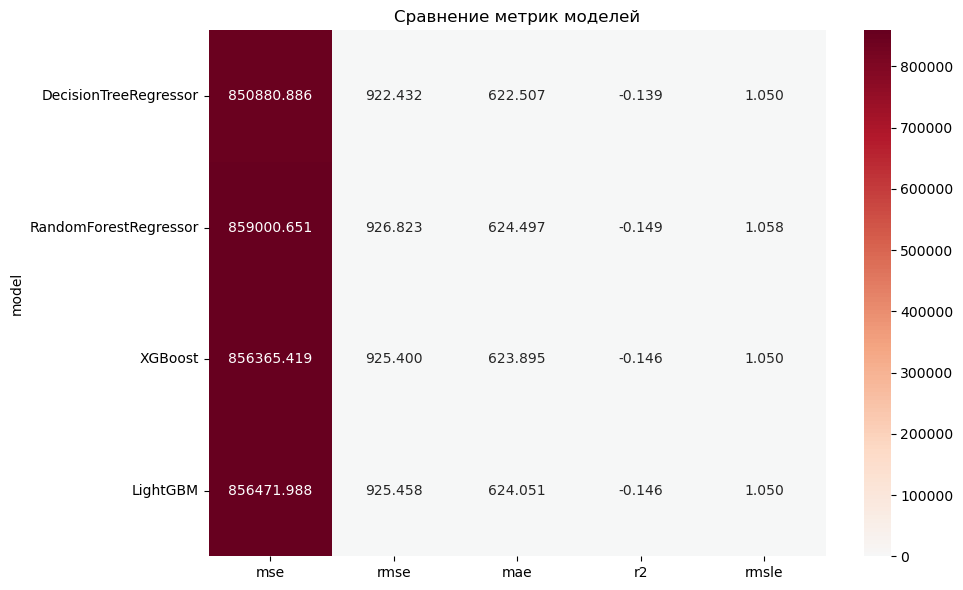

,mse,rmse,mae,r2,rmsle
model,,,,,
DecisionTreeRegressor,979.648602,0.531167,0.010695,-0.001311,-0.000178
RandomForestRegressor,-1696.329085,-0.914680,-1.024817,0.002270,-0.001334
XGBoost,-1024.773217,-0.553526,-0.776556,0.001371,-0.001432
LightGBM,-607.329154,-0.328066,-0.688733,0.000813,-0.001203


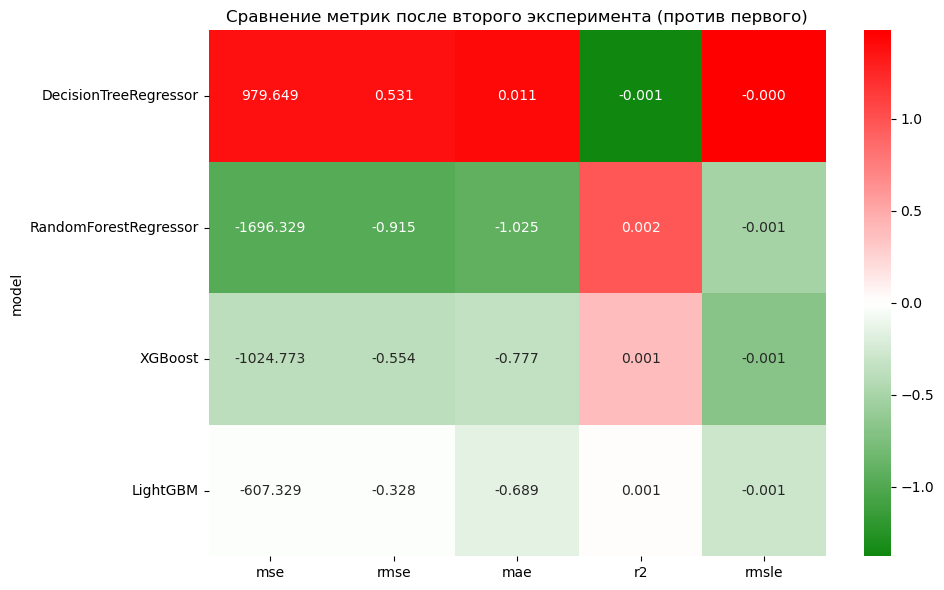

In [10]:
df_exp2 = calculate_health_bins(df_exp1)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2 = get_baseline_preprocessing(df_exp2, numerical_features, binary_features, ordinal_features, nominal_features)
exp2_results = run_experiment(X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2,
                             "Бинаризация рейтинга здоровья")


exp2_metrics = compare_models_metrics(exp2_results)

compare_after_add(exp2_metrics, exp1_metrics, 'Сравнение метрик после второго эксперимента (против первого)')

Видим аналогичные первому подходу улучшения метрик, идем дальше

### Подход №3 

Для того чтобы модели могли лучше уловить нелинейные зависимости, ведем два новых признака взаимодействий - между возрастом и рейтингом здоровья и возрастом автомобиля клиента и кол-вом предыдущих обращений.

In [11]:
def calculate_policy_season(df):
    """
    Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента
    """
    df["Age_Health"] = df["Age"] * df["Health_Score"]

    df["VehicleAge_Claims"] = df["Vehicle_Age"] * df["Previous_Claims"]

    return df


ЭКСПЕРИМЕНТ: Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента
Train shape: (960000, 43), Test shape: (240000, 43)
{'model': 'DecisionTreeRegressor', 'mse': 850818.6937498149, 'rmse': np.float64(922.398337894109), 'mae': 622.3085721762382, 'r2': -0.13854557019144464, 'rmsle': np.float64(1.0502890011306316)}
{'model': 'RandomForestRegressor', 'mse': 859001.58382443, 'rmse': np.float64(926.8233832961002), 'mae': 624.5001170789895, 'r2': -0.1494957212803394, 'rmsle': np.float64(1.0582654691319344)}
{'model': 'XGBoost', 'mse': 856434.1280096594, 'rmse': np.float64(925.4372631408676), 'mae': 623.8912370271047, 'r2': -0.1460600122790643, 'rmsle': np.float64(1.0502376474405182)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129

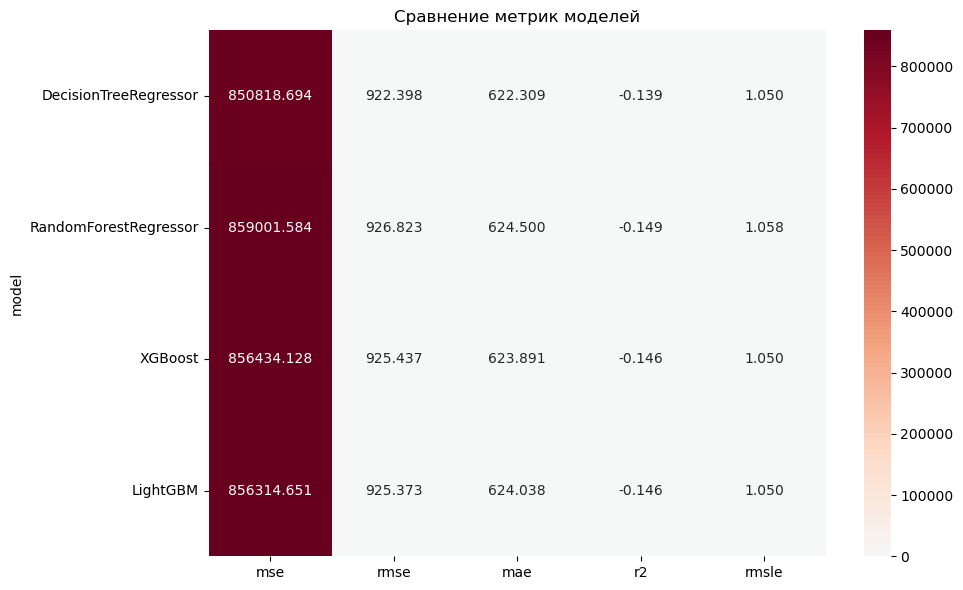

,mse,rmse,mae,r2,rmsle
model,,,,,
DecisionTreeRegressor,-62.192594,-0.033712,-0.198905,0.000083,-1.189030e-04
RandomForestRegressor,0.932443,0.000503,0.002829,-0.000001,9.246329e-07
XGBoost,68.708520,0.037123,-0.003868,-0.000092,2.103748e-05
LightGBM,-157.337134,-0.085009,-0.013464,0.000211,-7.858075e-06


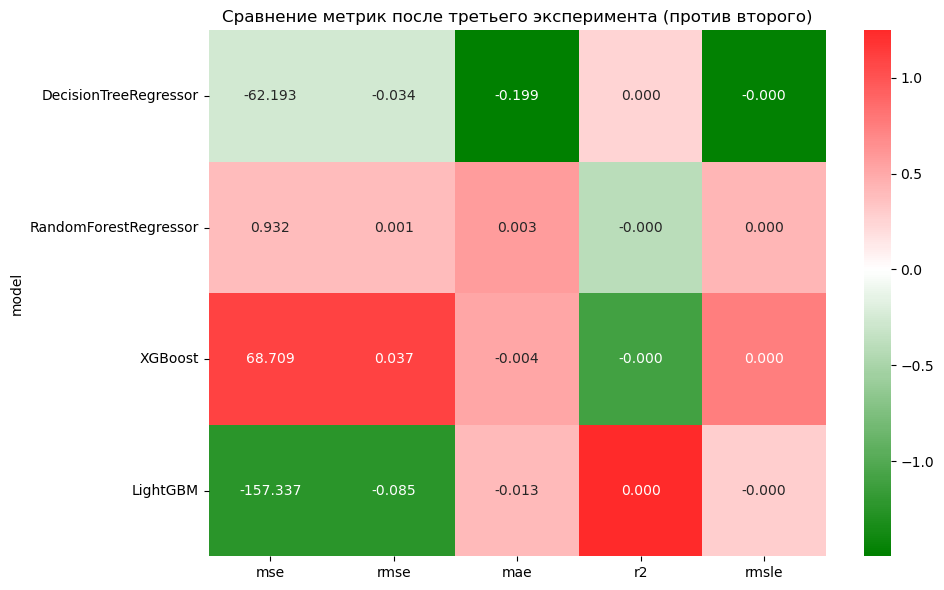

In [12]:
df_exp3 = calculate_policy_season(df_exp2)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day', 'Age_Health', 'VehicleAge_Claims'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type',
]


X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3 = get_baseline_preprocessing(df_exp3, numerical_features, binary_features, ordinal_features, nominal_features)
exp3_results = run_experiment(X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3,
                                "Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента")

exp3_metrics = compare_models_metrics(exp3_results)
compare_after_add(exp3_metrics, exp2_metrics, 'Сравнение метрик после третьего эксперимента (против второго)')


Метрики особо сильно не улучшились, но при этом и не ухудшулись. Оставим их, возможно они смогут внести свой вклад при подборе гиперпараметров

## Подход 4

Ну и в последнем подходе, ко всем существующим признакам, добавим признак взаимодействия - здоровья и предыдущих страховых случаев. Было бы логично, если цены на страховку у больных людей с частыми обращениями были выше, чем у здоровых клиентов без факта страховых случаев

In [13]:
def create_interaction_features(df):
    """
    Комбинация здоровья и предыдущих страховых случаев
    """
    df["Health_Claims"] = df["Health_Score"] * df["Previous_Claims"]

    return df


ЭКСПЕРИМЕНТ: Создание комбинированных признаков
Train shape: (960000, 44), Test shape: (240000, 44)
{'model': 'DecisionTreeRegressor', 'mse': 850734.2163904246, 'rmse': np.float64(922.3525445242858), 'mae': 622.3384728750603, 'r2': -0.13843252457547273, 'rmsle': np.float64(1.0501931560460038)}
{'model': 'RandomForestRegressor', 'mse': 859024.777805625, 'rmse': np.float64(926.8358958335747), 'mae': 624.5044803228972, 'r2': -0.1495267589206013, 'rmsle': np.float64(1.0582657693606974)}
{'model': 'XGBoost', 'mse': 856290.2717185869, 'rmse': np.float64(925.3595364606057), 'mae': 623.9089748776754, 'r2': -0.14586750717292585, 'rmsle': np.float64(1.050234893680564)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 960000, numbe

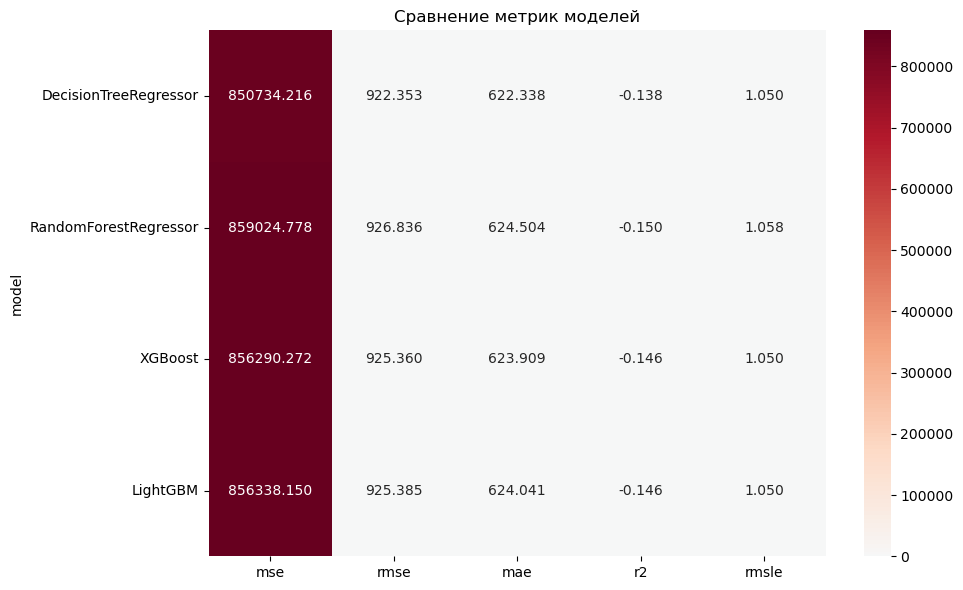

,mse,rmse,mae,r2,rmsle
model,,,,,
DecisionTreeRegressor,-84.477359,-0.045793,0.029901,0.000113,-9.584508e-05
RandomForestRegressor,23.193981,0.012513,0.004363,-0.000031,3.002288e-07
XGBoost,-143.856291,-0.077727,0.017738,0.000193,-2.753760e-06
LightGBM,23.499089,0.012697,0.003336,-0.000031,1.795504e-05


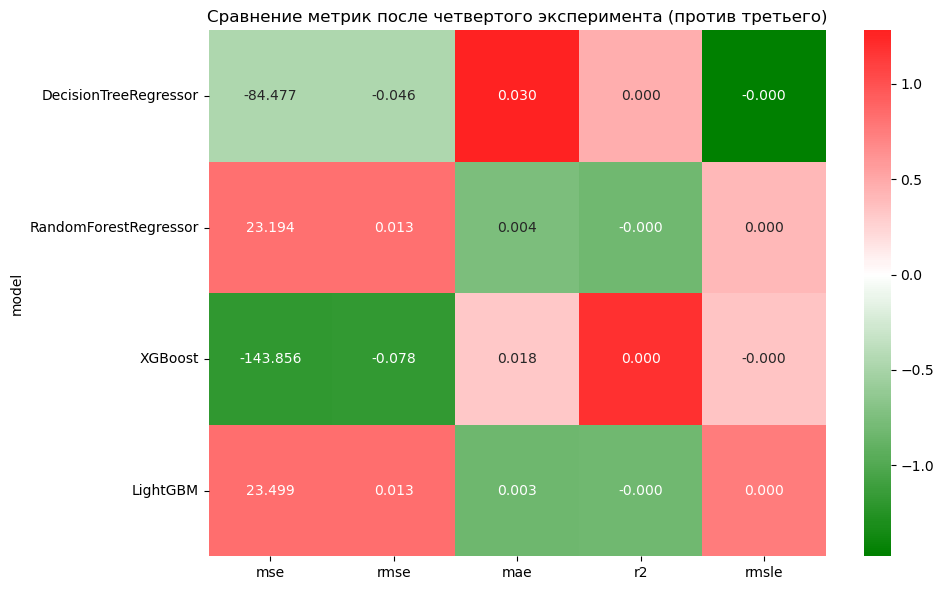

In [77]:
df_exp4 = create_interaction_features(df_exp3)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day',
    'Age_Health','VehicleAge_Claims','Health_Claims'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]



X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4 = get_baseline_preprocessing(df_exp4, numerical_features, binary_features, ordinal_features, nominal_features)
exp4_results = run_experiment(X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4,
                                "Создание комбинированных признаков")

exp4_metrics = compare_models_metrics(exp4_results)
compare_after_add(exp4_metrics, exp3_metrics, 'Сравнение метрик после четвертого эксперимента (против третьего)')


Тут аналогично, каких то сильных изменений нет, как и в предыдущем случае - оставляем

Итого после всех преобразований, метрики по сравнению с бейзлайном увеличелись следующим образом:

,mse,rmse,mae,r2,rmsle
model,,,,,
DecisionTreeRegressor,967.915201,0.524848,-0.475673,-0.001295,-0.000546
RandomForestRegressor,-3348.309816,-1.804555,-2.036715,0.004481,-0.003332
XGBoost,-3457.072238,-1.866080,-1.526022,0.004626,-0.003083
LightGBM,-2550.552299,-1.377078,-1.189349,0.003413,-0.002289


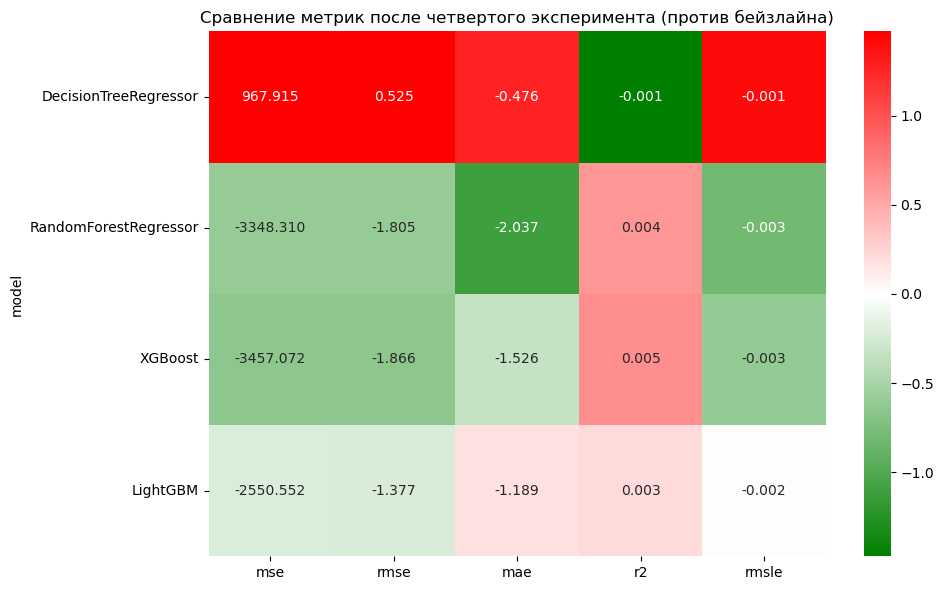

In [78]:
compare_after_add(exp4_metrics, baseline_metrics, 'Сравнение метрик после четвертого эксперимента (против бейзлайна)')

По сравнению со временем и качеством, на данный момент выигрывает модель XGBoost. Будем пробовать подобрать к нему гиперпараметры и улучшить метрики

**Вывод**: таким образом, было проведено три эксперимента, в ходе которых добавлены 4 признака. Recall увеличился на 0.2, однако precision почти не изменился. Будем пробовать улучшить метрики путем подбора гиперпараметров.